Thanks to :

    https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data
    https://www.kaggle.com/rluethy/efficientnet3d-with-one-mri-type
    https://www.kaggle.com/ammarnassanalhajali/brain-tumor-3d-training
    https://www.kaggle.com/ammarnassanalhajali/brain-tumor-3d-inference
    https://keras.io/examples/vision/3D_image_classification/
    

In [1]:
import glob
import re
import math
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from random import shuffle
from sklearn import model_selection as sk_model_selection

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

Num GPUs Available:  1


# Loading Data

In [4]:
# data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'
# pytorch3dpath = "../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D"

data_directory = ''
mri_types_orig = ['FLAIR','T1w','T1wCE','T2w']
mri_types = ['FLAIR','T1wCE','T2w']

IMAGE_SIZE = 128
NUM_IMAGES_PER_TYPE = 32
NUM_IMAGES = NUM_IMAGES_PER_TYPE * len(mri_types)
BATCH_SIZE= 4

train_df = pd.read_csv("train_labels.csv")

to_exclude = [109, 123, 709]
train_df = train_df[~train_df['BraTS21ID'].isin(to_exclude)]

train_df['BraTS21ID5'] = [format(x, '05d') for x in train_df.BraTS21ID]
print(len(train_df))
train_df.head(3)

582


,BraTS21ID,MGMT_value,BraTS21ID5
0,0,1,00000
1,2,1,00002
2,3,0,00003


In [5]:
sample_submission = pd.read_csv('sample_submission.csv')
test=sample_submission
test['BraTS21ID5'] = [format(x, '05d') for x in test.BraTS21ID]
test.head(3)

,BraTS21ID,MGMT_value,BraTS21ID5
0,1,0.5,00001
1,13,0.5,00013
2,15,0.5,00015


# Functions to load images


In [6]:
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, split = 'train', mri_type="FLAIR", num_imgs=NUM_IMAGES_PER_TYPE, img_size=IMAGE_SIZE, rotate=0):

    files = sorted(glob.glob(f"{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2:2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

def load_dicom_images_3d_all(scan_id, split = 'train'):
    img3d_all = np.concatenate([load_dicom_images_3d(scan_id, split, mri_type) for mri_type in mri_types], axis = -1)
    
    return img3d_all

a = load_dicom_images_3d_all("00001", 'test')
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))

(1, 128, 128, 96)
0.0 1.0 0.05042612946665817 0.0


# Splitting Data

In [7]:
df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=12, 
    stratify=train_df["MGMT_value"],
    shuffle=True,
)

In [8]:
df_train
del train_df

#  Custom Data Generator

In [9]:
from tensorflow.keras.utils import Sequence

class Dataset(Sequence):
    def __init__(self,df,split = 'train', is_train=True,batch_size=BATCH_SIZE,shuffle=True):
        self.idx = df["BraTS21ID"].values
        self.paths = df["BraTS21ID5"].values
        self.y =  df["MGMT_value"].values
        self.is_train = is_train
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.split = split
        
    def __len__(self):
        return math.ceil(len(self.idx))
   
    def __getitem__(self,ids):
        id_path= self.paths[ids]
        batch_paths = self.paths[ids * self.batch_size:(ids + 1) * self.batch_size]
        split=self.split
        
        if self.y is not None:
            y = self.y[ids]
            y = np.array(y)
            y = np.expand_dims(y, axis = 0)
            # batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
            
        # list_x =  load_dicom_images_3d(id_path)  #str(scan_id).zfill(5)
        # list_x =  [load_dicom_images_3d(x, split) for x in batch_paths]
        # list_x =  [load_dicom_images_3d_all(x, split) for x in batch_paths]
        # batch_X = np.stack(list_x, axis=4)
        X = load_dicom_images_3d_all(id_path, split)
        X = np.expand_dims(X, axis=4)
        if self.is_train:
            # return batch_X, batch_y
            return X, y
        else:
            # return batch_X
            return X


In [10]:
train_dataset = Dataset(df_train, 'train')
valid_dataset = Dataset(df_valid, 'train')
test_dataset = Dataset(test, 'test', is_train=False)

print(len(train_dataset))
print(type(train_dataset))
print([type(a) for a in train_dataset[0]])
print([a.shape for a in train_dataset[0]])

print(len(test_dataset))
print([a.shape for a in test_dataset[0]])
# print(test_dataset[0][0].shape)
print(type(train_dataset[0]))
print(type(valid_dataset))

465
<class '__main__.Dataset'>
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
[(1, 128, 128, 96, 1), (1,)]
87
[(128, 128, 96, 1)]
<class 'tuple'>
<class '__main__.Dataset'>


In [11]:
# def plot_sample_all(images, label, j): 
#     plt.figure(figsize=(35, 35))
#     for i in range(NUM_IMAGES):
#         plt.subplot(14,14,(i+1))
# #         plt.subplot(16,16,(i+1))
#         plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
#         plt.imshow(images[0,:,:,i,j], cmap="gray")
#     plt.show()

def plot_sample_all(images, label): 
    plt.figure(figsize=(35, 35))
    for i in range(NUM_IMAGES):
        plt.subplot(14,14,(i+1))
#         plt.subplot(16,16,(i+1))
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[0,:,:,i], cmap="gray")
    plt.show()

In [12]:
# i = 0
# j = 0
# images, label = train_dataset[j]
# plot_sample_all(images, label)
# # plot_sample_all(images, label, j)

In [13]:
# i = 0
# j = 1
# images, label = train_dataset[j]
# # plot_sample_all(images, label, j)
# plot_sample_all(images, label)

In [14]:
# i = 0
# j = 2
# images, label = train_dataset[j]
# # plot_sample_all(images, label, j)
# plot_sample_all(images, label)

In [15]:
# i = 0
# j = 3
# images, label = train_dataset[j]
# # plot_sample_all(images, label, j)
# plot_sample_all(images, label)

In [16]:
# def plot_sample_train(images, label): 
#     plt.figure(figsize=(16, 16))
#     idx_base = int(NUM_IMAGES_PER_TYPE/2)
# #     idx = [idx_base, idx_base*3, idx_base*5, idx_base*7]
#     idx = [idx_base, idx_base*3, idx_base*5]
#     for i in range(len(idx)*BATCH_SIZE):
#         plt.subplot(BATCH_SIZE,len(idx),i+1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
#         j = int(i/len(idx))
#         plt.imshow(images[0,:,:,idx[i%len(idx)],j], cmap="gray")
#         plt.xlabel(f'{idx[i%len(idx)]} {label[j]}')
#     plt.show()

def plot_sample_train(images, label): 
    plt.figure(figsize=(16, 16))
    idx_base = int(NUM_IMAGES_PER_TYPE/2)
#     idx = [idx_base, idx_base*3, idx_base*5, idx_base*7]
    idx = [idx_base, idx_base*3, idx_base*5]
    for i in range(len(idx)):
        plt.subplot(1,len(idx),i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[0,:,:,idx[i%len(idx)]], cmap="gray")
        plt.xlabel(f'{idx[i%len(idx)]} {label}')
    plt.show()

Dimension of the CT scan is: (1, 128, 128, 96, 1)
label= [0] (1,)


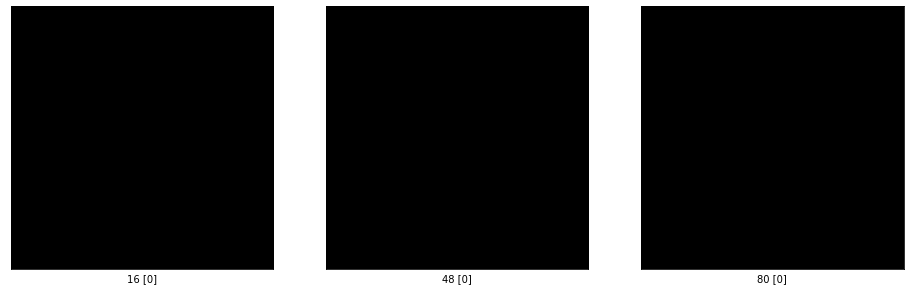

Dimension of the CT scan is: (1, 128, 128, 96, 1)
label= [0] (1,)


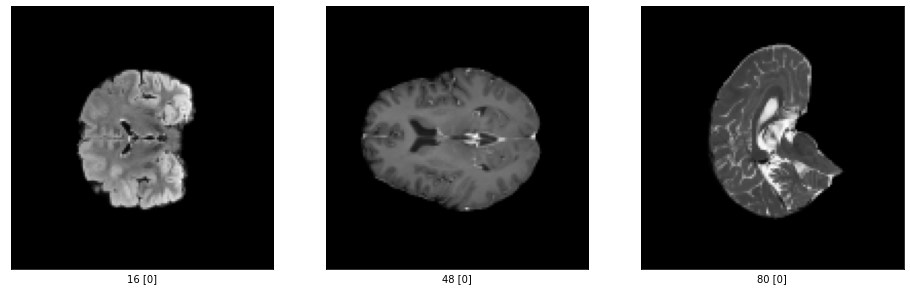

Dimension of the CT scan is: (1, 128, 128, 96, 1)
label= [1] (1,)


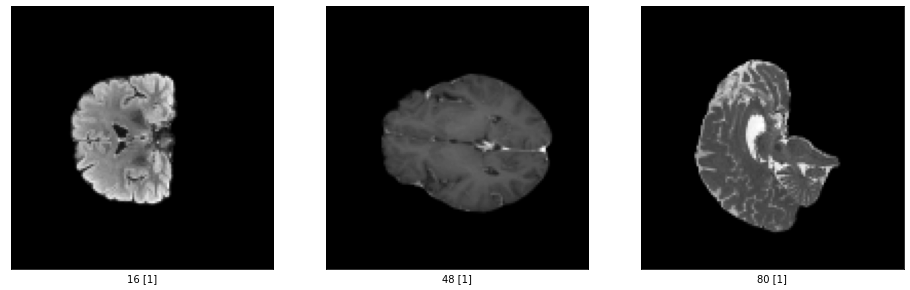

Dimension of the CT scan is: (1, 128, 128, 96, 1)
label= [1] (1,)


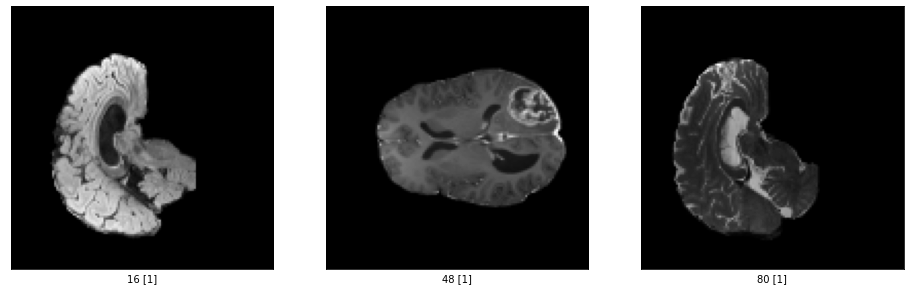

In [17]:
for i in range(BATCH_SIZE):
    images, label = train_dataset[i]
    print("Dimension of the CT scan is:", images.shape)
    print("label=",label ,label.shape)
    plot_sample_train(images, label)

In [18]:
# i = 0
# images, label = train_dataset[i]
# print("Dimension of the CT scan is:", images.shape)
# print("label=",label ,label.shape)
# plot_sample_train(images, label)

In [19]:
# def plot_sample_test(images): 
#     plt.figure(figsize=(16, 16))
#     idx_base = int(NUM_IMAGES_PER_TYPE/2)
# #     idx = [idx_base, idx_base*3, idx_base*5, idx_base*7]
#     idx = [idx_base, idx_base*3, idx_base*5]
#     for i in range(len(idx)*BATCH_SIZE):
#         plt.subplot(BATCH_SIZE,len(idx),i+1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
#         j = int(i/len(idx))
#         plt.imshow(images[0,:,:,idx[i%len(idx)],j], cmap="gray")
#         plt.xlabel(idx[i%len(idx)])
#     plt.show()

In [20]:
# i = 0
# images = test_dataset[i]
# print("Dimension of the CT scan is:", images.shape)
# plot_sample_test(images)

In [21]:
train_dataset[0][1]

array([0], dtype=int64)

# Model

In [22]:
def get_model(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=NUM_IMAGES):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=32, kernel_size=2, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=32, kernel_size=2, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)

#     x = layers.Conv3D(filters=256, kernel_size=2, activation="relu")(x)
#     x = layers.BatchNormalization()(x)
    
#     x = layers.Conv3D(filters=256, kernel_size=2, activation="relu")(x)
#     x = layers.BatchNormalization()(x)
    
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.Dropout(0.2)(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3D_CNN")

    return model

In [23]:
# Build model.
model = get_model()
model.summary()

Model: "3D_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 96, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 127, 127, 95, 32)  288       
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 127, 95, 32)  128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 126, 126, 94, 32)  8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 94, 32)  128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 47, 32)    0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 47, 32)    0    

# Training

In [24]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[AUC(name='auc'),"acc"],
)
# Define callbacks.
# checkpoint_cb = ModelCheckpoint('Brain_Tumor_All_MRI_3D_CNN.h5', 
#                                 save_best_only = True)
# early_stopping_cb = EarlyStopping(monitor = 'val_acc', 
#                                   patience = 15,
#                                   restore_best_weights = True)

checkpoint_cb = ModelCheckpoint('Brain_Tumor_All_MRI_3D_CNN.h5', 
                             save_best_only = True, 
                             monitor = 'val_auc', 
                             mode = 'max', verbose = 1)
early_stopping_cb = EarlyStopping(monitor = 'val_auc', 
                           patience = 1, mode = 'max', verbose = 1,
                           restore_best_weights = True)

# Train the model, doing validation at the end of each epoch
epochs = 100

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks = [checkpoint_cb, early_stopping_cb],
)

Epoch 1/100


KeyboardInterrupt: 

# Visualizing model performance

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Error: Session cannot generate requests

In [ ]:
model.save('Brain_Tumor_All_MRI_3D_CNN_Model.model')

In [ ]:
model.load_weights('./Brain_Tumor_All_MRI_3D_CNN.h5')

In [ ]:
predictions = model.predict(test_dataset)
predictions = predictions.reshape(-1)

In [ ]:
submission = pd.DataFrame({'BraTS21ID':sample_submission['BraTS21ID'],'MGMT_value':predictions})

In [ ]:
submission

In [ ]:
submission.to_csv('submission.csv',index=False)